In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageStat
from skimage import io, util, color
from scipy.optimize import linear_sum_assignment
import sys
import cv2
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
import os

HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content/weights


In [6]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-g15pp3_2
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-g15pp3_2
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=af75795bad2183d2963078da163fd02dd188495a2dbce2489b6a160c43b779e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-bz355jsw/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [7]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requi

In [8]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [9]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [10]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [11]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [12]:
mask_generator = SamAutomaticMaskGenerator(sam)

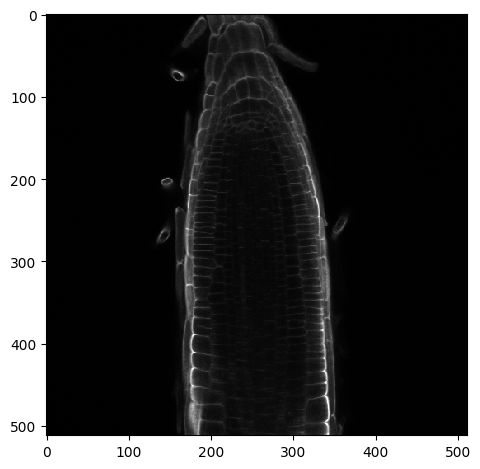

In [39]:
# image = io.imread("/content/WER 2-PBS_Ch1-T2_ORG.tif")
# image = io.imread("/content/drive/MyDrive/consolidated_images/6.png")

image = io.imread("/content/drive/MyDrive/Sanchari Confocal Images_2/3.tif")
if image.shape[2] > 3:
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image1 = io.imread("/content/020422_At1_7d_long_meristem_CW_jpegfile_rgb.jpg")
# image1 = image[0]
# io.imshow(image1[7])
# io.imshow(image1)
io.imshow(image)

In [202]:
import supervision as sv
sam_result = mask_generator.generate(image)

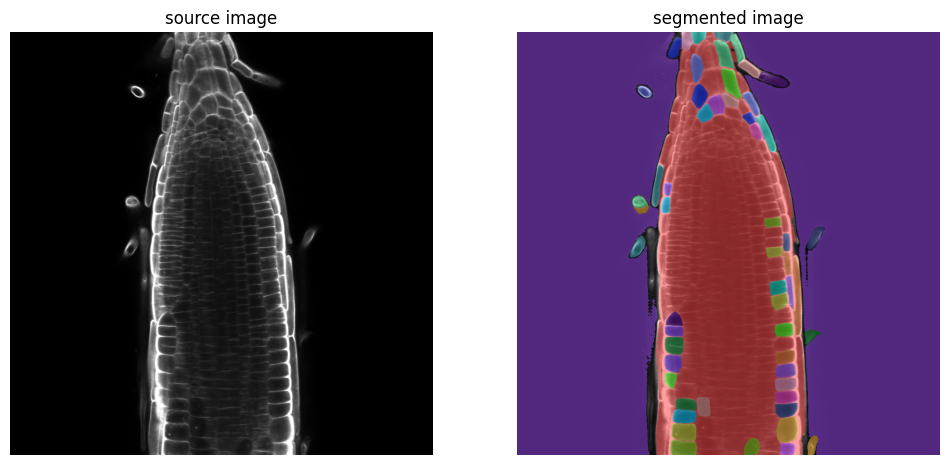

In [203]:
mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)

sv.plot_images_grid(
    images=[image, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image'])

In [204]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

In [205]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

# Assume you have a list of masks (mask_list) and an example image_to_byte_array function
# Replace these with your actual data

# Initialize variables
selected_masks = [False] * len(masks)

# Create a grid layout to display masks and checkboxes
grid_layout = widgets.GridspecLayout(len(masks), 3, width='60%')
mask_widgets = []

# Function to toggle mask selection
def toggle_selection(change, index):
    selected_masks[index] = not selected_masks[index]

# Function to display masks and checkboxes
def display_masks():
    for i, mask in enumerate(masks):
        checkbox = widgets.Checkbox(value=False, description='Include')
        checkbox.observe(lambda change, index=i: toggle_selection(change, index), names='value')

        mask_widgets.append(widgets.Image(value=image_to_byte_array(mask), format="png"))
        mask_widgets[-1].layout.height = '200px'

        # original_widget = widgets.Image(value=image_to_byte_array(image), format="png")
        # original_widget.layout.height = '200px'

        grid_layout[i, 0] = checkbox
        grid_layout[i, 1] = mask_widgets[-1]
        # grid_layout[i, 2] = original_widget

# Convert NumPy array to byte array for display
def image_to_byte_array(image):
    from io import BytesIO
    img_byte_array = BytesIO()
    plt.imsave(img_byte_array, image, format='png')
    return img_byte_array.getvalue()

# Display the masks and checkboxes
display_masks()

# Create a button to apply the selection
apply_button = widgets.Button(description="Apply Selection")
output = widgets.Output()

# Function to apply the selection and create new lists
def apply_selection(_):
    global selected_masks
    global unselected_masks

    # Create new lists for selected and unselected masks
    selected_mask_list = [mask for mask, selected in zip(masks, selected_masks) if not selected]
    unselected_mask_list = [mask for mask, selected in zip(masks, selected_masks) if selected]

    # Update mask_list and selected_masks
    selected_masks = selected_mask_list
    # unselected_masks = [False] * len(masks)
    unselected_masks = unselected_mask_list

    with output:
        print("Selected images discarded.")
        print("Unselected images included.")


# Bind button action
apply_button.on_click(apply_selection)


# Display the checkboxes, images, and the Apply button
display(widgets.VBox([grid_layout, apply_button, output]))


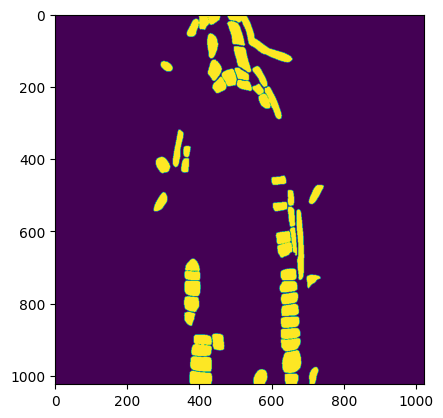

In [207]:
import numpy as np

# Assuming you have a list of object masks (masks) and an image size (image_height, image_width)

# Initialize an empty mask with the same dimensions as your image
empty_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

# Iterate through the 10 individual object masks and combine them
for object_mask in selected_masks:
    empty_mask = np.logical_or(empty_mask, object_mask)

plt.imshow(empty_mask)

In [208]:
len(selected_masks)

57

In [209]:
len(unselected_masks)

2

In [210]:
with open(f"/content/drive/MyDrive/sanchari_masks_pkl/masks20.pkl", 'rb') as file:
    total_masks = pickle.load(file)

In [211]:
no_prompt_masks = len(total_masks) - len(selected_masks)
print(no_prompt_masks)

118


In [24]:
with open(f"/content/drive/MyDrive/finetune_sanchari_masks/masks20.pkl", 'rb') as file:
    total_masks = pickle.load(file)
print(len(total_masks))

219


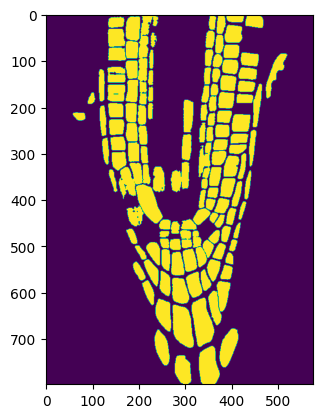

In [ ]:
import numpy as np

# Assuming you have a list of object masks (masks) and an image size (image_height, image_width)

# Initialize an empty mask with the same dimensions as your image
empty_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

# Iterate through the 10 individual object masks and combine them
i = 0
for object_mask in total_masks:

    empty_mask = np.logical_or(empty_mask, object_mask)

plt.imshow(empty_mask)

In [ ]:
object_mask.shape

(1024, 1024)

In [ ]:
import supervision as sv
sv.plot_images_grid(
    images=total_masks,
    # grid_size=(16, int(len(masks) / 16)),
    grid_size= (1600, 1600),
    size=(10, 10)
)

In [ ]:
print(filename)

38.tif


In [ ]:
with open(f"/content/drive/MyDrive/training_dataset/masks_sanchari.pkl", 'wb') as file:
  pickle.dump(masks, file)
with open(f"/content/drive/MyDrive/training_dataset/images_sanchari.pkl", 'wb') as file:
  pickle.dump(images, file)

## PlantSeg - detection rate

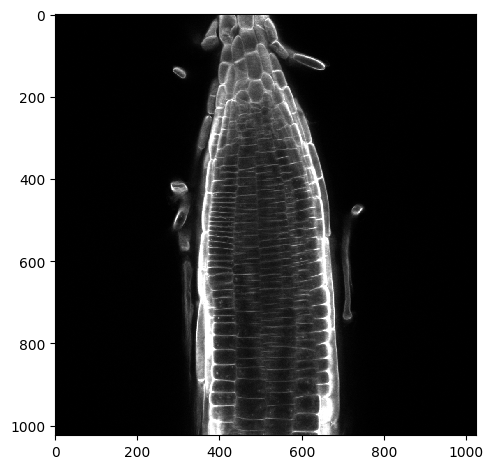

In [133]:
# image = io.imread("/content/WER 2-PBS_Ch1-T2_ORG.tif")
# image = io.imread("/content/drive/MyDrive/consolidated_images/6.png")

image = io.imread("/content/drive/MyDrive/Sanchari Confocal Images_2/17.tif")
if image.shape[2] > 3:
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image1 = io.imread("/content/020422_At1_7d_long_meristem_CW_jpegfile_rgb.jpg")
# image1 = image[0]
# io.imshow(image1[7])
# io.imshow(image1)
io.imshow(image)

<ipython-input-139-dee9c2c52d72>:23: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 172201 to uint16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  img[i,j] = newColor
<ipython-input-139-dee9c2c52d72>:26: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 172201 to uint16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  img[i,j] = colorMatrix[g]
<ipython-input-139-dee9c2c52d72>:23: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 394501 to uint16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast

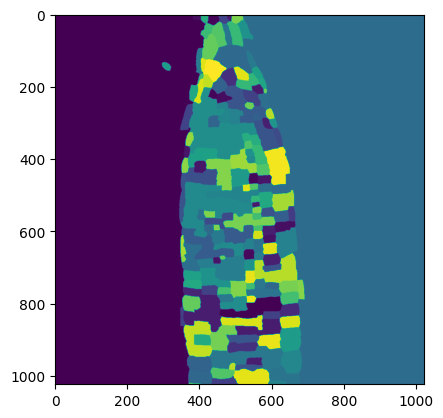

In [139]:
from PIL import Image
import random
# image = Image.open("/content/drive/MyDrive/Imput Image and Segmented image/020422_At1_7d_long_meristem_CW_graystack8bit_predictions_multicut.tiff")
image2 = io.imread("/content/20_stack_predictions_multicut.tiff")
# image = Image.open("/content/drive/MyDrive/Imput Image and Segmented image/032823_Es_root_tip3_8bit_C=0_predictions_multicut.tiff")
colorMatrix = {}
colorList = []
colors = range(1, 500000, 100) # 25, 50, 100
oldColor = 0
seg_img = []
for img in image2:
  for i in range(len(img)):
    for j in range(len(img)):
      g = img[i,j]
      if g == 1:
        img[i,j] = 255
      elif g not in colorMatrix:
        newColor = colors[random.randint(0, len(colors) - 1)]
        while(newColor in colorList or (newColor < (oldColor + 100) and newColor > (oldColor - 250))):
          newColor = colors[random.randint(0, len(colors) - 1)] + 100
        colorList.append(newColor)
        colorMatrix[g] = newColor
        img[i,j] = newColor
        oldColor = newColor
      else:
        img[i,j] = colorMatrix[g]
        oldColor = colorMatrix[g]
  seg_img.append(img)
plt.imshow(seg_img[7])

In [140]:
unique_labels = np.unique(image2[0])
masks2 = []
for label in unique_labels:
    # Create a mask for the current label
    mask1 = (image2[0] == label).astype(np.uint8)
    masks2.append(mask1)


In [141]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

# Assume you have a list of masks (mask_list) and an example image_to_byte_array function
# Replace these with your actual data

# Initialize variables
selected_masks = [False] * len(masks2)

# Create a grid layout to display masks and checkboxes
grid_layout = widgets.GridspecLayout(len(masks2), 3, width='60%')
mask_widgets = []

# Function to toggle mask selection
def toggle_selection(change, index):
    selected_masks[index] = not selected_masks[index]

# Function to display masks and checkboxes
def display_masks():
    for i, mask in enumerate(masks2):
        checkbox = widgets.Checkbox(value=False, description='Include')
        checkbox.observe(lambda change, index=i: toggle_selection(change, index), names='value')

        mask_widgets.append(widgets.Image(value=image_to_byte_array(mask), format="png"))
        mask_widgets[-1].layout.height = '200px'

        # original_widget = widgets.Image(value=image_to_byte_array(image), format="png")
        # original_widget.layout.height = '200px'

        grid_layout[i, 0] = checkbox
        grid_layout[i, 1] = mask_widgets[-1]
        # grid_layout[i, 2] = original_widget

# Convert NumPy array to byte array for display
def image_to_byte_array(image):
    from io import BytesIO
    img_byte_array = BytesIO()
    plt.imsave(img_byte_array, image, format='png')
    return img_byte_array.getvalue()

# Display the masks and checkboxes
display_masks()

# Create a button to apply the selection
apply_button = widgets.Button(description="Apply Selection")
output = widgets.Output()

# Function to apply the selection and create new lists
def apply_selection(_):
    global selected_masks
    global unselected_masks

    # Create new lists for selected and unselected masks
    selected_mask_list = [mask for mask, selected in zip(masks2, selected_masks) if not selected]
    unselected_mask_list = [mask for mask, selected in zip(masks2, selected_masks) if selected]

    # Update mask_list and selected_masks
    selected_masks = selected_mask_list
    # unselected_masks = [False] * len(masks)
    unselected_masks = unselected_mask_list

    with output:
        print("Selected images discarded.")
        print("Unselected images included.")


# Bind button action
apply_button.on_click(apply_selection)


# Display the checkboxes, images, and the Apply button
display(widgets.VBox([grid_layout, apply_button, output]))


In [142]:
len(selected_masks)

100

In [143]:
len(unselected_masks)

67

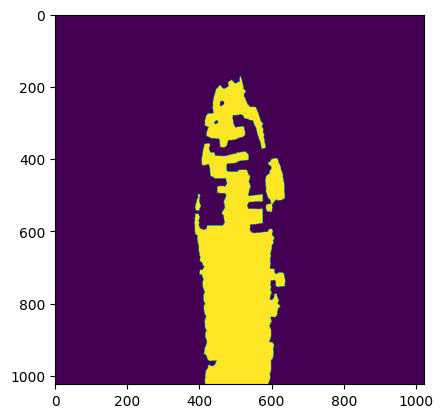

In [57]:
import numpy as np

# Assuming you have a list of object masks (masks) and an image size (image_height, image_width)

# Initialize an empty mask with the same dimensions as your image
empty_mask = np.zeros((image2[0].shape[0], image2[0].shape[1]), dtype=np.uint8)

# Iterate through the 10 individual object masks and combine them
for object_mask in selected_masks:
    empty_mask = np.logical_or(empty_mask, object_mask)

plt.imshow(empty_mask)